<a href="https://colab.research.google.com/github/ddevMetal/CSCI218/blob/main/CSCI323_Lab_1_for_students_cifar10_tutorial4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCI323 Lab 1 Assignment (2025)
**Content modified by: Cher Lim** (cherl@uow.edu.au)

<b>Name: Teo Choun Meng</b>

**7-digit UOW ID:** 7919591

##Instructions:
1. There are three sections (A, B, C) in this notebook.
2. Run the code per section and review the computation results.
3. Answer the questions **supported by your computation results**. Provide **explanation** to your answers to demonstrate your understanding of the relevant concepts.  
4. You will print the entire notebook (answers, computation results) into **PDF and submit to Moodle**.

### A. Exploring the dataset (2 marks)
Review the t-SNE visualization outputs in Section A.

1. List 4 pairs of classes that are heavily overlapped. (1 mark)
2. The t-SNE visualization gives us a 'starting point' view of our data. What can you implement in a basic CNN model to better separate these overlapping classes? Give 5 suggestions. (1 mark)



### Write your answers here:

###B. Training the model (2 marks)
You are provided with a dataset of N samples. You split it into training and validation set with a ratio of 70:30.
You then set the batch_size = k for your training.

1. How many times does the model update its weights? (1 mark)
2. How does batch size affect the model performance? (1 mark)

### Write your answers here:

### C. Role of activation function (6 marks)
You will train 3 CNN models:
* A standard CNN model with no activation function at the output layer.
* A non-standard CNN model with ReLU at the output layer.
* A non-standard CNN model with Tanh at the output layer.

Answer the following questions. Your answers must be supported by the **computation results** of your codes and the relevant concepts.

1. For each model above, discuss the impact on the output distribution and model performance. (3 marks)

2. Should an activation function be placed at the output layer prior to SoftMax? Explain your answer. (3 marks)

### Write your answers here:

#Learning objectives:

1. Extracts insights from a database.
2. Translate insights into a game plan.
3. Understanding the architecture of a basic CNN.
4. Interpret the training process of a neural network model.
5. Investigate the impact of activation functions at the OUTPUT layer of a CNN model.

A. Exploring the dataset
=====================

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a `torch.*Tensor`.

-   For images, packages such as Pillow, OpenCV are useful
-   For audio, packages such as scipy and librosa
-   For text, either raw Python or Cython based loading, or NLTK and
    SpaCy are useful

Specifically for vision, we have created a package called `torchvision`,
that has data loaders for common datasets such as ImageNet, CIFAR10,
MNIST, etc. and data transformers for images, viz.,
`torchvision.datasets` and `torch.utils.data.DataLoader`.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset. It has the classes:
'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
'ship', 'truck'. The images in CIFAR-10 are of size 3x32x32, i.e.
3-channel color images of 32x32 pixels in size.

![cifar10](https://pytorch.org/tutorials/_static/img/cifar10.png)



### A-1. Load and normalize CIFAR10

Using `torchvision`, it's extremely easy to load CIFAR10.


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

#### Normalize dataset images during loading

Normalizing dataset images during loading is a *standard practice in deep learning*. **It converts original pixel values range from [0,1] to [-1,1].**

Benefits include:
* Centers the data around zero
* Makes the input distribution more symmetrical.
* Makes the data more compatible with activation functions.

To normalise the image during loading:

1. ToTensor(): Converts images from PIL format (0-255 range) to torch tensors with values in [0, 1]
2. Normalize(): Applies the formula: **(x - mean) / std** to each channel

Given:
* mean = (0.5, 0.5, 0.5)
* std = (0.5, 0.5, 0.5)

Using the formula in (2), normalized_x = (x - 0.5) / 0.5.

Hence, **normalized_x = 2x - 1**

Original pixel values range [0, 1] now becomes [-1, 1].

To display the images using Matplotlib, we need to **unnormalize** the image. That means we are solving for x.

x = (normalized_x + 1) / 2

Hence, x = (normalized_x / 2) +  0.5  (formula used in the code).

*Let's test*: normalized_x range [-1,1], x range [0,1]. So that's correct!

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Each batch has 4 samples. Hence, 12,500 (=50k/4) batches per epoch.
# Model updates its weights once per batch, so 12,500 updates per epoch.
batch_size = 4


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### A-2. Check out the dataset

In [3]:
from collections import Counter

Training set size: 50000 images
Test set size: 10000 images
Total dataset size: 60000 images
Image dimensions: torch.Size([3, 32, 32])
Image type: torch.float32

Class distribution in training set:
Class frog: 5000 images
Class truck: 5000 images
Class deer: 5000 images
Class car: 5000 images
Class bird: 5000 images
Class horse: 5000 images
Class ship: 5000 images
Class cat: 5000 images
Class dog: 5000 images
Class plane: 5000 images


Let us show some of the training images, for fun.


In [5]:
"""
The imshow function displays an image using Matplotlib, typically for PyTorch tensors. It takes a normalized image tensor (shape: channels, height, width),
unnnormalizes it by scaling values from [-1, 1] to [0, 1], converts it to a NumPy array, transposes it to (height, width, channels) for Matplotlib compatibility,
and then shows the image. It's used in deep learning to visualize dataset images or model outputs.
Dependencies: Requires numpy, matplotlib.pyplot, and a PyTorch tensor input.
"""
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

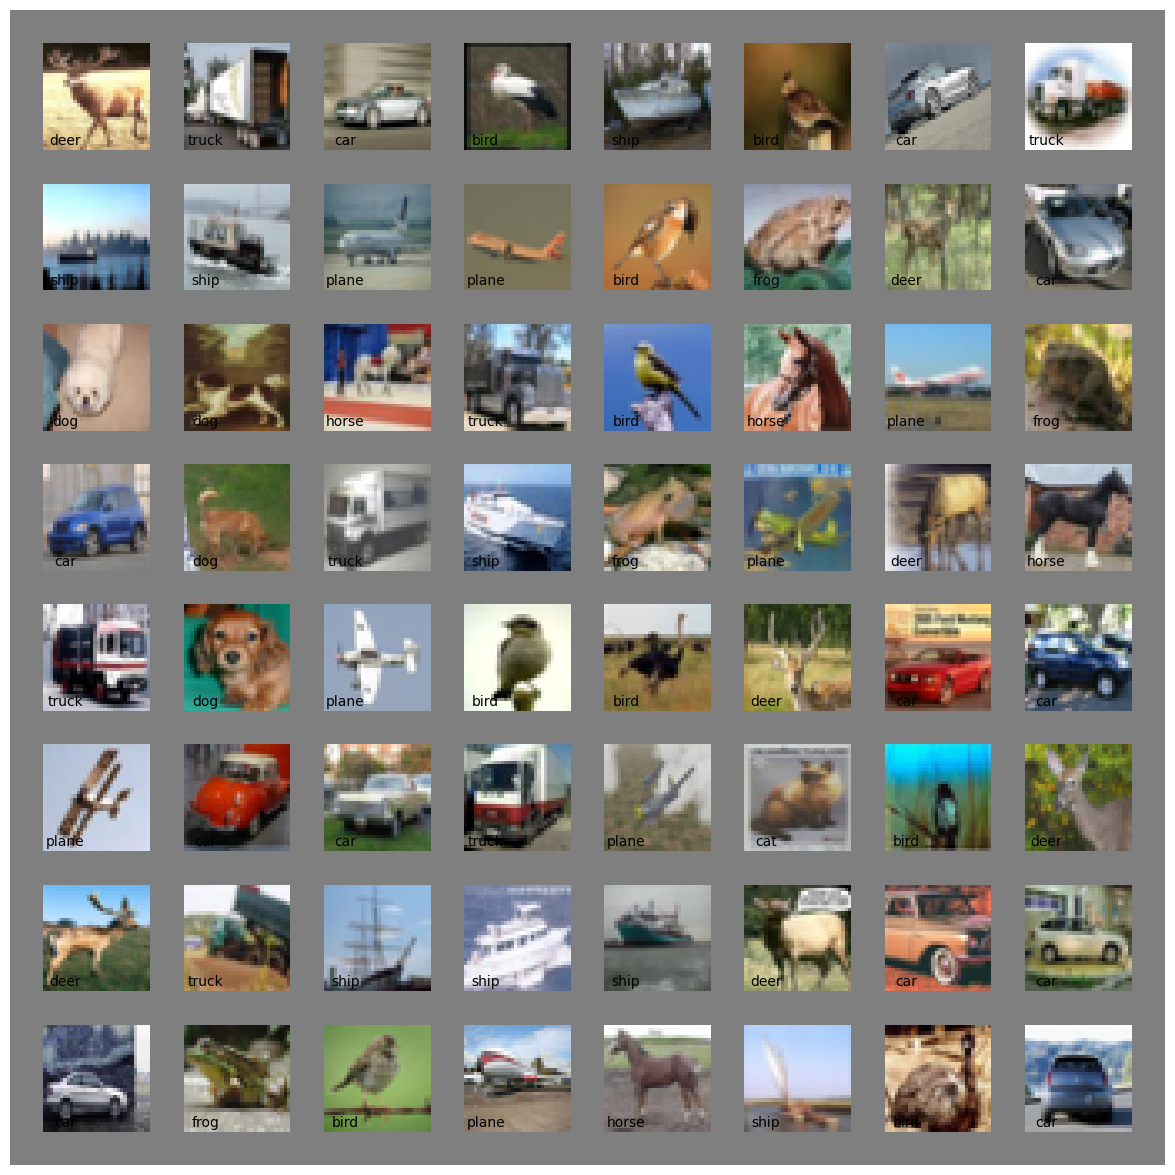

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def show_image_grid(images, labels, nrow=8):  # Changed nrow to 5 for a 5x5 grid
    img_grid = torchvision.utils.make_grid(images, nrow=nrow, padding=10) # Combines multiple images into a single grid tensor.
    img_grid = img_grid / 2 + 0.5  # unnormalize
    npimg = img_grid.numpy()

    plt.figure(figsize=(15, 15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

    # Add class labels as text
    for i, label in enumerate(labels[:len(images)]):
        row = i // nrow
        col = i % nrow
        plt.text(col * (32 + 10) + 16, row * (32 + 10) + 40,
                 classes[label], ha='center')

    plt.show()

# Usage with 25 images
images_list = []
labels_list = []
for i in range(64):  # Get 25 images
    if i % 4 == 0:
        dataiter = iter(trainloader)
    img, lbl = next(dataiter)
    images_list.append(img[0])
    labels_list.append(lbl[0])

show_image_grid(images_list, labels_list)

### A-3. Run t-SNE on raw pixel values
When you run t-SNE on raw pixel values, each image in CIFAR-10 starts as a high-dimensional vector (**3,072 dimensions for 32×32×3 RGB images**).

The t-SNE algorithm then finds a way to project these high-dimensional points onto a 2D plane while trying to preserve the relative distances between points. (Similar to the idea of PCA).

The x and y axes in the resulting plot are simply the two dimensions that t-SNE creates to represent the data.

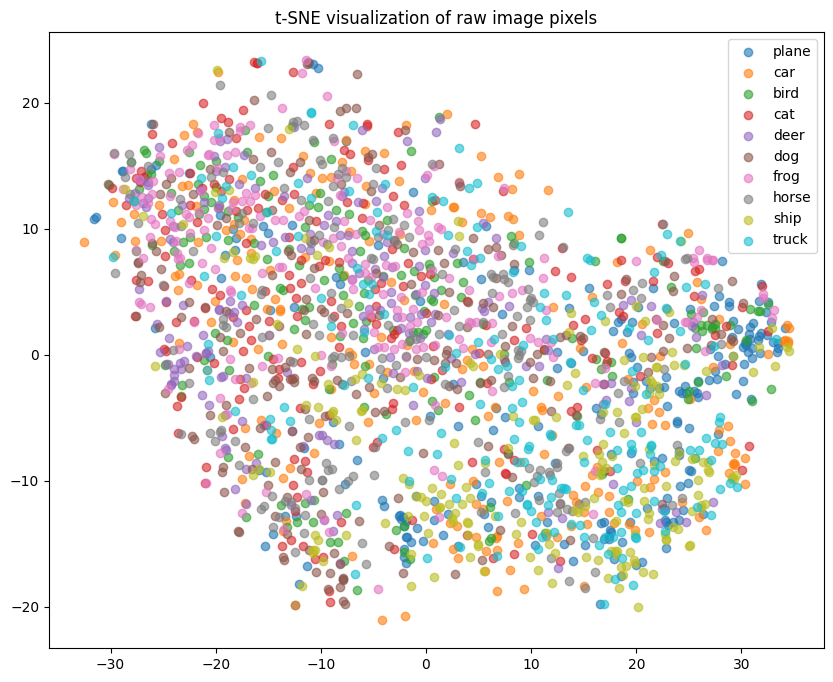

In [7]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Get a subset of images (for speed)
subset_size = 2000
subset_indices = np.random.choice(len(trainset), subset_size, replace=False)

# Extract raw images and labels
images = []
labels = []
for idx in subset_indices:
    img, label = trainset[idx]
    # Flatten the image to a vector
    images.append(img.view(-1).numpy())
    labels.append(label)

images = np.array(images)
labels = np.array(labels)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
images_tsne = tsne.fit_transform(images)

# Plot
plt.figure(figsize=(10, 8))
for i in range(10):
    indices = labels == i
    plt.scatter(images_tsne[indices, 0], images_tsne[indices, 1], label=classes[i], alpha=0.6)
plt.legend()
plt.title('t-SNE visualization of raw image pixels')
plt.show()

### A-4. Calculate the Euclidean distance between each pair of classes

In [8]:
from sklearn.metrics import pairwise_distances
import pandas as pd

centroids = []
for i in range(10):
    class_points = images_tsne[labels == i]
    centroid = class_points.mean(axis=0)
    centroids.append(centroid)

# Calculate pairwise distances
dist_matrix = pairwise_distances(centroids)

# Create labeled DataFrame
dist_df = pd.DataFrame(dist_matrix, index=classes, columns=classes)

# Print the matrix (rounded for clarity)
print("\nPairwise class centroid distances in t-SNE space (rounded):\n")
print(dist_df.to_string(formatters={col: '{:.2f}'.format for col in dist_df.columns}))


Pairwise class centroid distances in t-SNE space (rounded):

      plane   car  bird   cat  deer   dog  frog horse  ship truck
plane  0.00 10.09 15.24 17.67 18.93 16.28 20.50 14.31  4.34  4.00
car   10.09  0.00  5.28  7.60  8.84  6.34 10.63  4.25 10.15  6.11
bird  15.24  5.28  0.00  2.61  4.09  3.32  5.36  2.23 15.39 11.31
cat   17.67  7.60  2.61  0.00  1.51  2.79  3.55  3.59 17.49 13.70
deer  18.93  8.84  4.09  1.51  0.00  3.14  3.50  4.65 18.51 14.94
dog   16.28  6.34  3.32  2.79  3.14  0.00  6.28  2.19 15.53 12.29
frog  20.50 10.63  5.36  3.55  3.50  6.28  0.00  7.01 20.73 16.62
horse 14.31  4.25  2.23  3.59  4.65  2.19  7.01  0.00 13.91 10.32
ship   4.34 10.15 15.39 17.49 18.51 15.53 20.73 13.91  0.00  5.04
truck  4.00  6.11 11.31 13.70 14.94 12.29 16.62 10.32  5.04  0.00


# B. Define a Convolutional Neural Network


1. The following section consists of **two identical CNN models** except one has ReLU after the final layer.
2. You will train both models and tracks their loss curves
Evaluates their performance on the test set
3. You will visualise:
  * Training loss comparison
  * Output value distributions (showing how ReLU truncates negative values)
  * Example outputs for specific classes with and without ReLU
4. You will compare accuracy overall and for each class

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# Define standard model without ReLU at final layer
class NetStandard(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Pass through fc3 (84 → 10)
        return x

In [10]:
# Training function
def train_model(net, trainloader, epochs=2):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:
                avg_loss = running_loss / 2000
                losses.append(avg_loss)
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}')
                running_loss = 0.0

    print('Finished Training')
    return losses

In [11]:
# Define model with ReLU at final layer
class NetWithFinalReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # Uncomment if you want to use LeakyReLU
        # self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Pass through fc3 (84 → 10)
        x = F.relu(x)    # Apply ReLU after fc3 (or use self.leaky_relu(x) if defined)
        return x

In [12]:
# Function to get example outputs
def get_sample_outputs(net, testloader):
    # Get a batch from the testloader
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    # Get outputs
    outputs = net(images)

    return outputs, labels

** ADDING DROP OUT RATE TO IMPROVE SEPARATION**

In [13]:
# Define model with Tanh at final layer
class NetWithFinalTanh(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))  # Tanh applied here
        return x

In [14]:
import torch.nn as nn
import torch.nn.functional as F

# Define standard model without ReLU at final layer, while adding dropout rate
class NetStandardWithDropOutRate(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.dropout1 = nn.Dropout(p=0.5)  # <-- Add this
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(p=0.3)  # <-- Add this
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)  # <-- Add this
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)  # <-- Add this
        x = self.fc3(x)
        return x

** CNN with TanH at output layer**

### B-1. Training the model

In [15]:
# Train both models
print("Training standard model (without final ReLU)...")
net_standard = NetStandard()
losses_standard = train_model(net_standard, trainloader)

print("\nTraining model with final ReLU...")
net_with_relu = NetWithFinalReLU()
losses_with_relu = train_model(net_with_relu, trainloader)

Training standard model (without final ReLU)...
[1,  2000] loss: 2.163
[1,  4000] loss: 1.840
[1,  6000] loss: 1.659
[1,  8000] loss: 1.586
[1, 10000] loss: 1.488
[1, 12000] loss: 1.459
[2,  2000] loss: 1.399
[2,  4000] loss: 1.338
[2,  6000] loss: 1.333
[2,  8000] loss: 1.307
[2, 10000] loss: 1.286
[2, 12000] loss: 1.260
Finished Training

Training model with final ReLU...
[1,  2000] loss: 2.247
[1,  4000] loss: 1.955
[1,  6000] loss: 1.716
[1,  8000] loss: 1.611
[1, 10000] loss: 1.545
[1, 12000] loss: 1.459
[2,  2000] loss: 1.399
[2,  4000] loss: 1.355
[2,  6000] loss: 1.357
[2,  8000] loss: 1.306
[2, 10000] loss: 1.284
[2, 12000] loss: 1.282
Finished Training


**  RESULT WITH TanH  ADDED as output layer **

In [16]:
# Train model for comparison
print("Training model with Tanh at output layer for comparison...")
net_with_tanh = NetWithFinalTanh()
losses_tanh = train_model(net_with_tanh, trainloader)

Training model with Tanh at output layer for comparison...
[1,  2000] loss: 2.188
[1,  4000] loss: 1.939
[1,  6000] loss: 1.847
[1,  8000] loss: 1.794
[1, 10000] loss: 1.740
[1, 12000] loss: 1.703
[2,  2000] loss: 1.664
[2,  4000] loss: 1.647
[2,  6000] loss: 1.631
[2,  8000] loss: 1.603
[2, 10000] loss: 1.616
[2, 12000] loss: 1.595
Finished Training


**  RESULT WITH DROP OUT RATE ADDED **

In [17]:
# Train model for comparison
print("Training standard model without REUL, plus added drop out rate for comparison....")
net_standard_with_dropout = NetStandardWithDropOutRate()
losses_standard = train_model(net_standard_with_dropout, trainloader)

Training standard model without REUL, plus added drop out rate for comparison....
[1,  2000] loss: 2.221
[1,  4000] loss: 1.956
[1,  6000] loss: 1.801
[1,  8000] loss: 1.736
[1, 10000] loss: 1.664
[1, 12000] loss: 1.629
[2,  2000] loss: 1.569
[2,  4000] loss: 1.533
[2,  6000] loss: 1.536
[2,  8000] loss: 1.497
[2, 10000] loss: 1.489
[2, 12000] loss: 1.482
Finished Training


### B-2. Save the models

In [1]:
PATH_S = './cifar_net_standard.pth'
torch.save(net_standard.state_dict(), PATH_S)
PATH_R = './cifar_net_with_relu.pth'
torch.save(net_with_relu.state_dict(), PATH_R)

NameError: name 'torch' is not defined

In [19]:
# Additionally added

PATH_SDR = './cifar_net_standard_with_dropout.pth'
torch.save(net_standard_with_dropout.state_dict(), PATH_SDR)


In [20]:
# Additionally added for Tanh

PATH_T = './cifar_net_with_tanh.pth'
torch.save(net_with_tanh.state_dict(), PATH_T)

Next, let\'s load back in our saved model (note: saving and re-loading
the model wasn\'t necessary here, we only did it to illustrate how to do
so):


In [21]:
#net = net_standard()
net_standard.load_state_dict(torch.load(PATH_S, weights_only=True))
net_with_relu.load_state_dict(torch.load(PATH_R, weights_only=True))

<All keys matched successfully>

In [22]:
net_standard_with_dropout.load_state_dict(torch.load(PATH_SDR, weights_only=True))

<All keys matched successfully>

In [23]:
net_with_tanh.load_state_dict(torch.load(PATH_T, weights_only=True))

<All keys matched successfully>

Okay, now let us see what the neural network thinks these examples above
are:


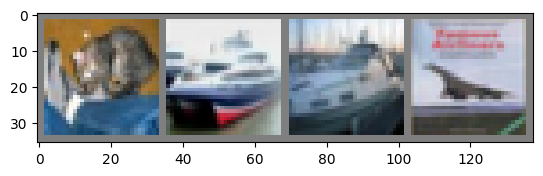

GroundTruth:  cat   ship  ship  plane


In [24]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [25]:
outputs_samples = net_standard(images)

In [26]:
_, predicted = torch.max(outputs_samples, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  car   ship 


#C. Investigate the impact of activation functions at the OUTPUT layer of a CNN model

### C-1. Visualize the training loss and Logit values of both models

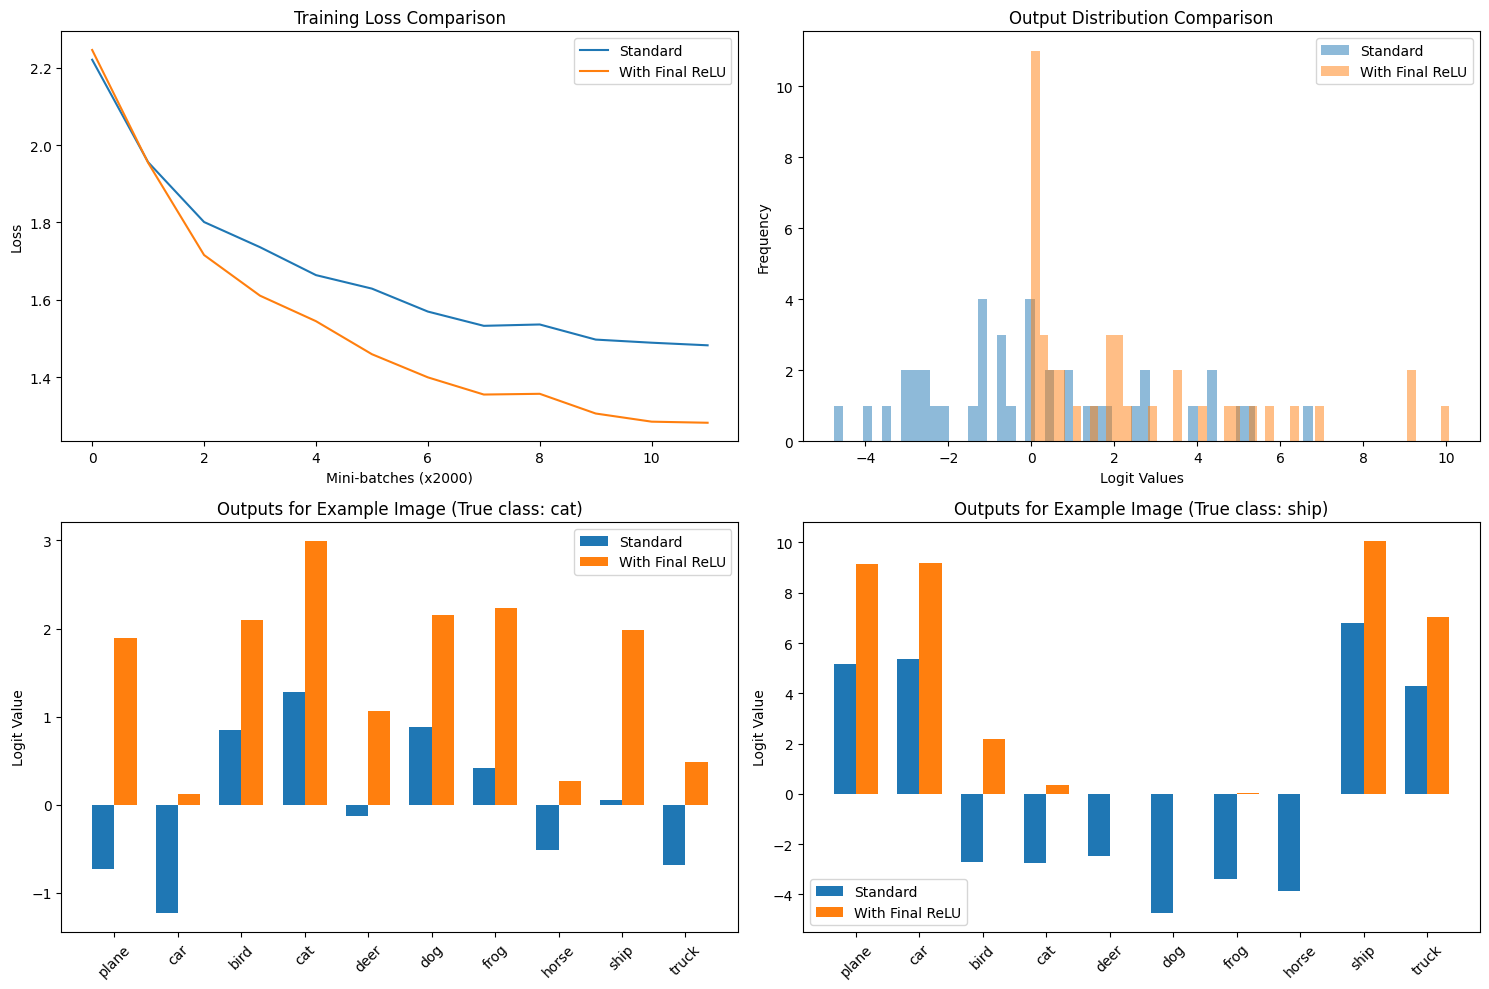

In [27]:
# Get sample outputs
outputs_standard, labels = get_sample_outputs(net_standard, testloader)
outputs_with_relu, _ = get_sample_outputs(net_with_relu, testloader)

# Convert to numpy for plotting
outputs_standard_np = outputs_standard.detach().numpy()
outputs_with_relu_np = outputs_with_relu.detach().numpy()
labels_np = labels.numpy()

# Visualize
plt.figure(figsize=(15, 10))

# Plot loss curves
plt.subplot(2, 2, 1)
plt.plot(losses_standard, label='Standard')
plt.plot(losses_with_relu, label='With Final ReLU')
plt.title('Training Loss Comparison')
plt.xlabel('Mini-batches (x2000)')
plt.ylabel('Loss')
plt.legend()

# Plot output distributions (histogram of logits)
plt.subplot(2, 2, 2)
plt.hist(outputs_standard_np.flatten(), bins=50, alpha=0.5, label='Standard')
plt.hist(outputs_with_relu_np.flatten(), bins=50, alpha=0.5, label='With Final ReLU')
plt.title('Output Distribution Comparison')
plt.xlabel('Logit Values')
plt.ylabel('Frequency')
plt.legend()

# Example comparison for specific images
plt.subplot(2, 2, 3)
example_idx = 0  # Select first image from batch
# Plot the output values for this example
standard_values = outputs_standard_np[example_idx]
relu_values = outputs_with_relu_np[example_idx]
true_label = labels_np[example_idx]

x = np.arange(10)
width = 0.35

plt.bar(x - width/2, standard_values, width, label='Standard')
plt.bar(x + width/2, relu_values, width, label='With Final ReLU')
plt.title(f'Outputs for Example Image (True class: {classes[true_label]})')
plt.xticks(x, classes, rotation=45)
plt.ylabel('Logit Value')
plt.legend()

# Add another example with a different class
plt.subplot(2, 2, 4)
for i in range(1, len(labels_np)):
    if labels_np[i] != labels_np[0]:  # Find example with different class
        example_idx = i
        break
else:
    example_idx = 1  # Fallback if all same class

standard_values = outputs_standard_np[example_idx]
relu_values = outputs_with_relu_np[example_idx]
true_label = labels_np[example_idx]

plt.bar(x - width/2, standard_values, width, label='Standard')
plt.bar(x + width/2, relu_values, width, label='With Final ReLU')
plt.title(f'Outputs for Example Image (True class: {classes[true_label]})')
plt.xticks(x, classes, rotation=45)
plt.ylabel('Logit Value')
plt.legend()

plt.tight_layout()
plt.show()

**Replace ReLu with Tanh**

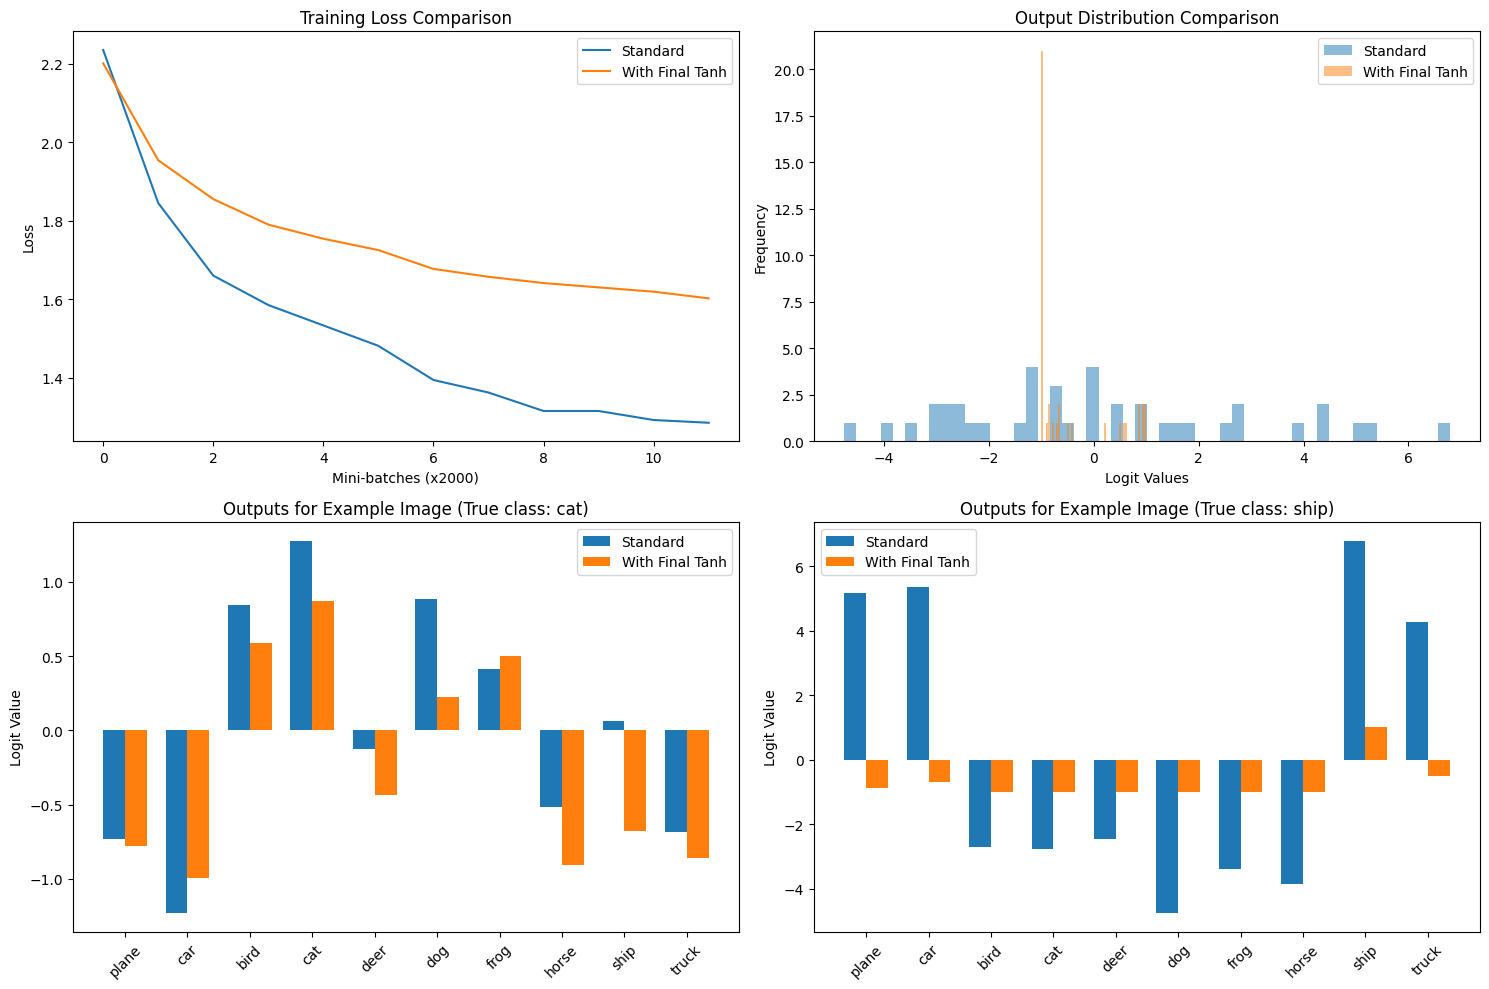

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Define loss arrays from training logs
losses_standard = [2.235, 1.845, 1.660, 1.585, 1.533, 1.481, 1.394, 1.362, 1.315, 1.315, 1.292, 1.285]
losses_with_tanh = [2.201, 1.954, 1.855, 1.790, 1.754, 1.725, 1.677, 1.657, 1.641, 1.630, 1.619, 1.602]

# Get sample outputs
outputs_standard, labels = get_sample_outputs(net_standard, testloader)
outputs_with_tanh, _ = get_sample_outputs(net_with_tanh, testloader)

# Convert to numpy for plotting
outputs_standard_np = outputs_standard.detach().numpy()
outputs_with_tanh_np = outputs_with_tanh.detach().numpy()
labels_np = labels.numpy()

# Visualize
plt.figure(figsize=(15, 10))

# Plot loss curves
plt.subplot(2, 2, 1)
plt.plot(losses_standard, label='Standard')
plt.plot(losses_with_tanh, label='With Final Tanh')
plt.title('Training Loss Comparison')
plt.xlabel('Mini-batches (x2000)')
plt.ylabel('Loss')
plt.legend()

# Plot output distributions (histogram of logits)
plt.subplot(2, 2, 2)
plt.hist(outputs_standard_np.flatten(), bins=50, alpha=0.5, label='Standard')
plt.hist(outputs_with_tanh_np.flatten(), bins=50, alpha=0.5, label='With Final Tanh')
plt.title('Output Distribution Comparison')
plt.xlabel('Logit Values')
plt.ylabel('Frequency')
plt.legend()

# Example comparison for specific images
plt.subplot(2, 2, 3)
example_idx = 0  # Select first image from batch
standard_values = outputs_standard_np[example_idx]
tanh_values = outputs_with_tanh_np[example_idx]
true_label = labels_np[example_idx]

x = np.arange(10)
width = 0.35

plt.bar(x - width/2, standard_values, width, label='Standard')
plt.bar(x + width/2, tanh_values, width, label='With Final Tanh')
plt.title(f'Outputs for Example Image (True class: {classes[true_label]})')
plt.xticks(x, classes, rotation=45)
plt.ylabel('Logit Value')
plt.legend()

# Add another example with a different class
plt.subplot(2, 2, 4)
for i in range(1, len(labels_np)):
    if labels_np[i] != labels_np[0]:  # Find example with different class
        example_idx = i
        break
else:
    example_idx = 1  # Fallback if all same class

standard_values = outputs_standard_np[example_idx]
tanh_values = outputs_with_tanh_np[example_idx]
true_label = labels_np[example_idx]

plt.bar(x - width/2, standard_values, width, label='Standard')
plt.bar(x + width/2, tanh_values, width, label='With Final Tanh')
plt.title(f'Outputs for Example Image (True class: {classes[true_label]})')
plt.xticks(x, classes, rotation=45)
plt.ylabel('Logit Value')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
# Get outputs from the model
outputs = net_with_relu(images)
print("Sample logits (first sample):", outputs[0])
print(f"Min logit: {outputs.min().item():.4f}")
print(f"Max logit: {outputs.max().item():.4f}")

# Convert to NumPy array for analysis
outputs_np = outputs.detach().numpy().flatten()

# Count total and negative logits
total_logits = outputs_np.size
num_negatives = np.sum(outputs_np < 0)

print(f"Total number of logit values: {total_logits}")
print(f"Number of negative logit values: {num_negatives}")
print(f"Percentage of negative values: {100 * num_negatives / total_logits:.2f}%")


Sample logits (first sample): tensor([1.8960, 0.1169, 2.0993, 2.9981, 1.0614, 2.1517, 2.2292, 0.2692, 1.9792,
        0.4892], grad_fn=<SelectBackward0>)
Min logit: 0.0000
Max logit: 10.0728
Total number of logit values: 40
Number of negative logit values: 0
Percentage of negative values: 0.00%


### C-2. Evaluate the models on test data

In [30]:
# Evaluate both models
def evaluate_model(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on test images: {accuracy:.2f}%')
    return accuracy

# Evaluate and print accuracy comparison
print("\nEvaluating standard model (without final ReLU)...")
accuracy_standard = evaluate_model(net_standard, testloader)

print("\nEvaluating model with final ReLU...")
accuracy_with_relu = evaluate_model(net_with_relu, testloader)

print("\nAccuracy Comparison:")
print(f"Standard Model: {accuracy_standard:.2f}%")
print(f"Model with Final ReLU: {accuracy_with_relu:.2f}%")


Evaluating standard model (without final ReLU)...
Accuracy on test images: 56.30%

Evaluating model with final ReLU...
Accuracy on test images: 53.11%

Accuracy Comparison:
Standard Model: 56.30%
Model with Final ReLU: 53.11%


### C-3. Accuracy per class in standard CNN model (without ReLU at output layer)


In [31]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# checking the CNN without ReLU at output
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net_standard(images) # checking the CNN without ReLU at output
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 59.4 %
Accuracy for class: car   is 76.8 %
Accuracy for class: bird  is 43.5 %
Accuracy for class: cat   is 29.6 %
Accuracy for class: deer  is 42.3 %
Accuracy for class: dog   is 62.3 %
Accuracy for class: frog  is 59.3 %
Accuracy for class: horse is 64.1 %
Accuracy for class: ship  is 63.9 %
Accuracy for class: truck is 61.8 %


### C-4. Accuracy per class in CNN model with ReLU at output layer

In [32]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# checking the CNN without ReLU at output
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net_with_relu(images) # checking the CNN with ReLU at output
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 76.2 %
Accuracy for class: car   is 81.5 %
Accuracy for class: bird  is 48.8 %
Accuracy for class: cat   is 26.0 %
Accuracy for class: deer  is 38.0 %
Accuracy for class: dog   is 25.0 %
Accuracy for class: frog  is 65.2 %
Accuracy for class: horse is 53.6 %
Accuracy for class: ship  is 57.5 %
Accuracy for class: truck is 59.3 %


### C-5. Confusion matrix for standard CNN model (without ReLU at output layer)


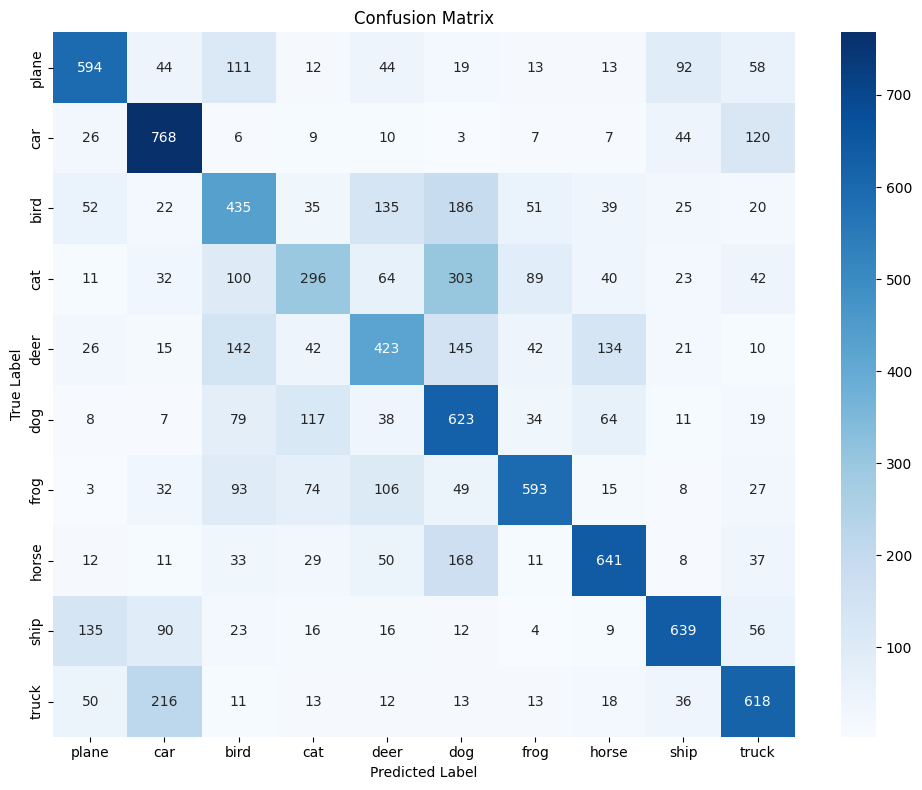

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Assuming: net is your trained model, testloader is your DataLoader, and classes is a list of class names
net_standard.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = net_standard(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### C-6.  Confusion matrix for CNN model with ReLU at output layer

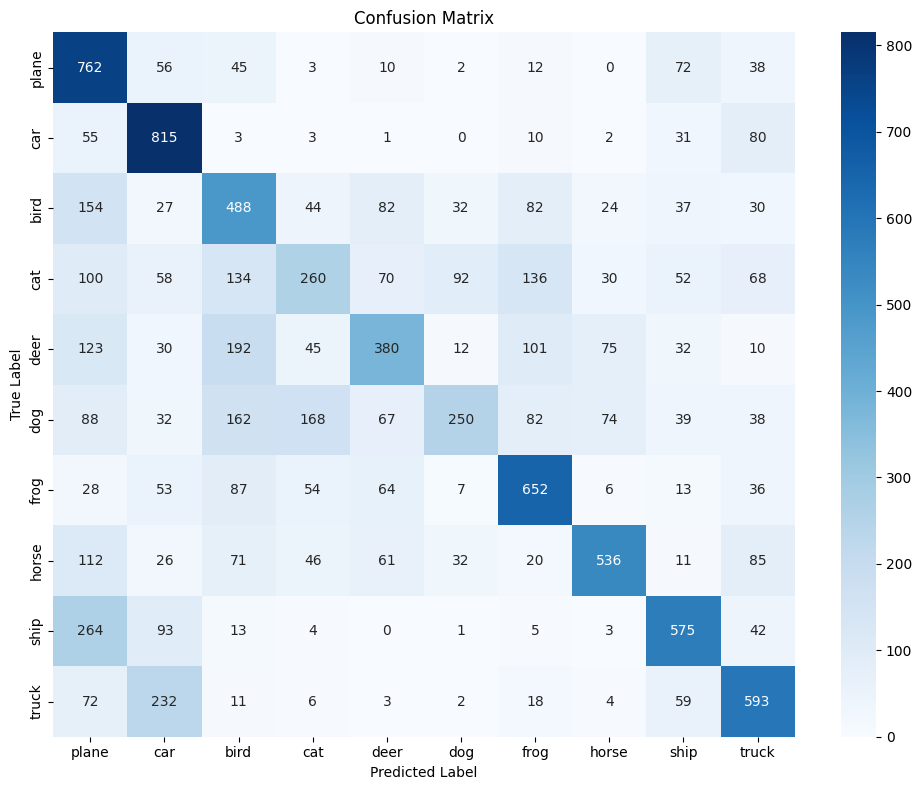

In [34]:
# Assuming: net is your trained model, testloader is your DataLoader, and classes is a list of class names
net_with_relu.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = net_with_relu(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# C-7. Saliency maps using GradCam
A saliency map highlights which regions of an image most influenced the model's classification decision. The **warmer colors (red, yellow) indicate areas of high importance**, while cooler colors (blue, green) show less influential regions.

When generating saliency maps, we're **visualizing the gradient flow back** through these activation functions to the input image. Different activation functions create different gradient landscapes.

Study the saliency map for the different models (standard CNN vs non-standard CNN). **What do you observe?**

In [35]:
!pip install grad-cam

In [36]:
# Import necessary libraries
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np
import torch


In [37]:
def visualize_saliency_maps(net, name):
    """
    Generate and display saliency maps for a given model

    Args:
        net: The trained model
        name: Name of the model for display purposes
    """
    # Select the target layer for visualization (last convolutional layer)
    target_layer = [net.conv2]

    # Initialize GradCAM
    cam = GradCAM(model=net, target_layers=target_layer)

    # Get a batch of test images
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    # Get model predictions
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)

    # Create a figure to display images and their saliency maps
    fig, axes = plt.subplots(4, 2, figsize=(12, 16))
    fig.suptitle(f'Saliency Maps for {name}', fontsize=16)

    for i in range(4):  # Process first 4 images of the batch
        # Original image
        img = images[i].cpu().numpy().transpose(1, 2, 0)
        img = img / 2 + 0.5  # unnormalize

        # Create saliency map
        input_tensor = images[i].unsqueeze(0)  # Add batch dimension
        grayscale_cam = cam(input_tensor=input_tensor, targets=None)
        grayscale_cam = grayscale_cam[0, :]

        # Overlay saliency map on original image
        visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)

        # Display original image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Original: {classes[labels[i]]}')
        axes[i, 0].axis('off')

        # Display saliency map
        axes[i, 1].imshow(visualization)
        axes[i, 1].set_title(f'Predicted: {classes[predicted[i]]}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()


Generating saliency maps for standard model (without final ReLU)...


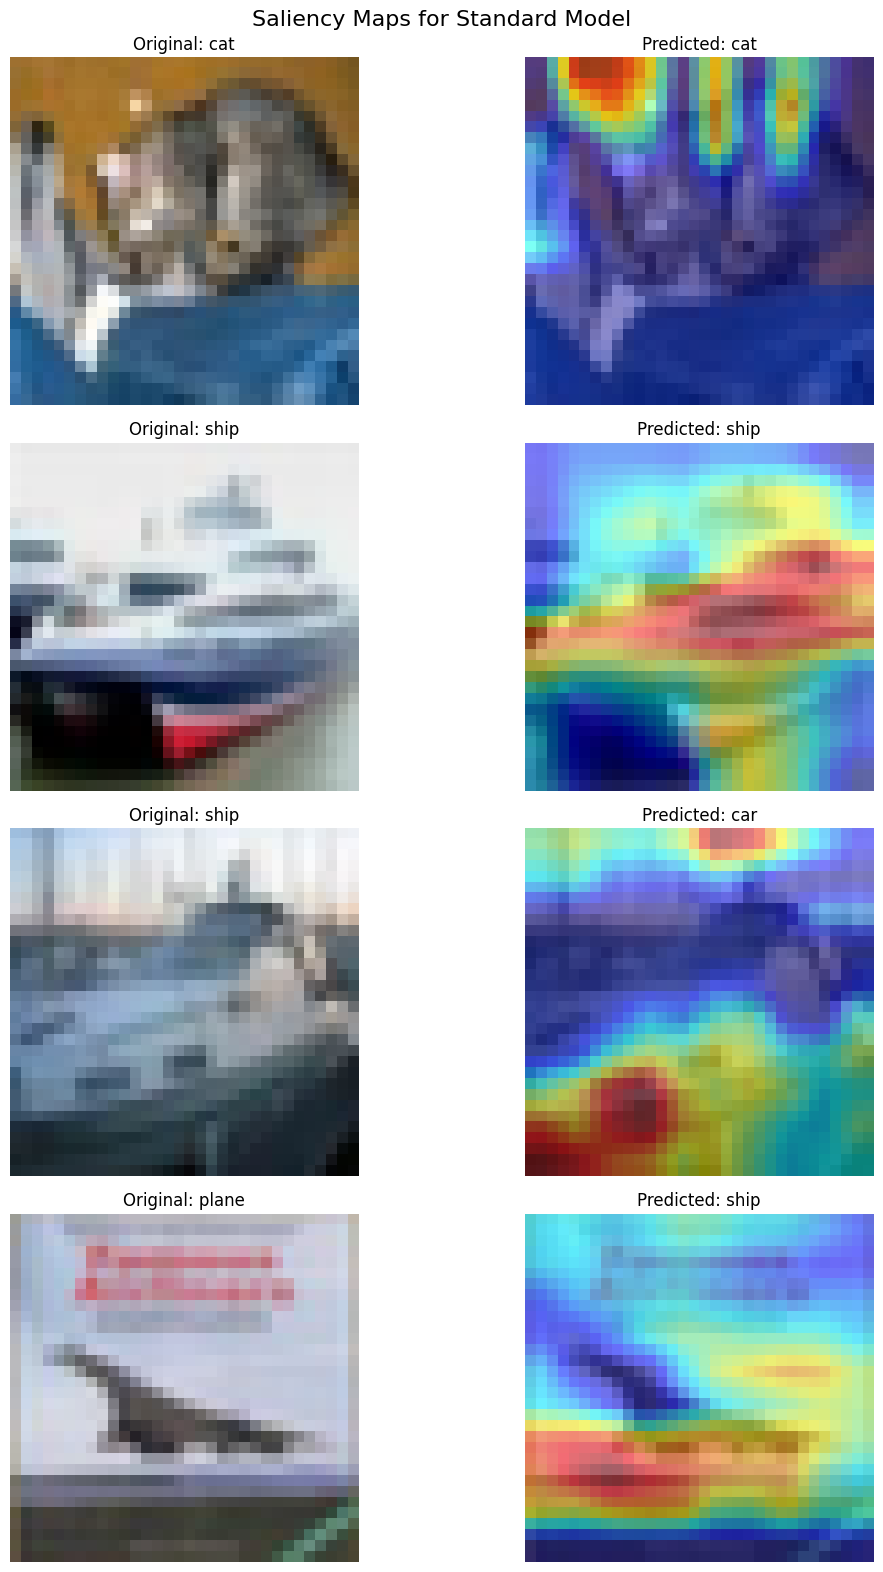


Generating saliency maps for model with final ReLU...


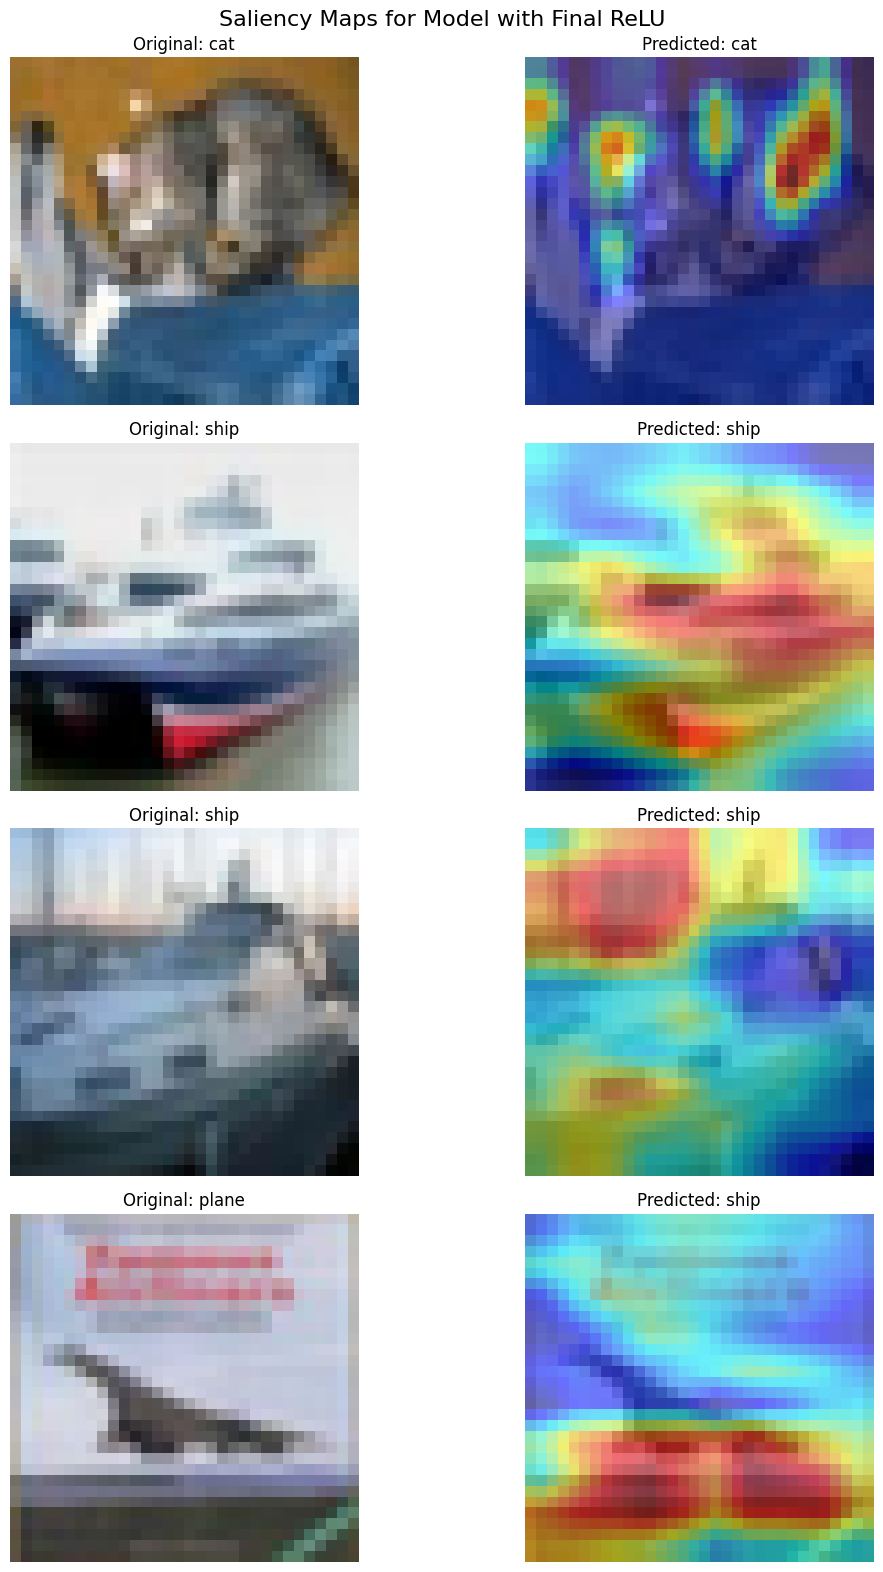

In [38]:
# Generate saliency maps for both models
print("Generating saliency maps for standard model (without final ReLU)...")
visualize_saliency_maps(net_standard, "Standard Model")

print("\nGenerating saliency maps for model with final ReLU...")
visualize_saliency_maps(net_with_relu, "Model with Final ReLU")



Generating side-by-side comparison of saliency maps...


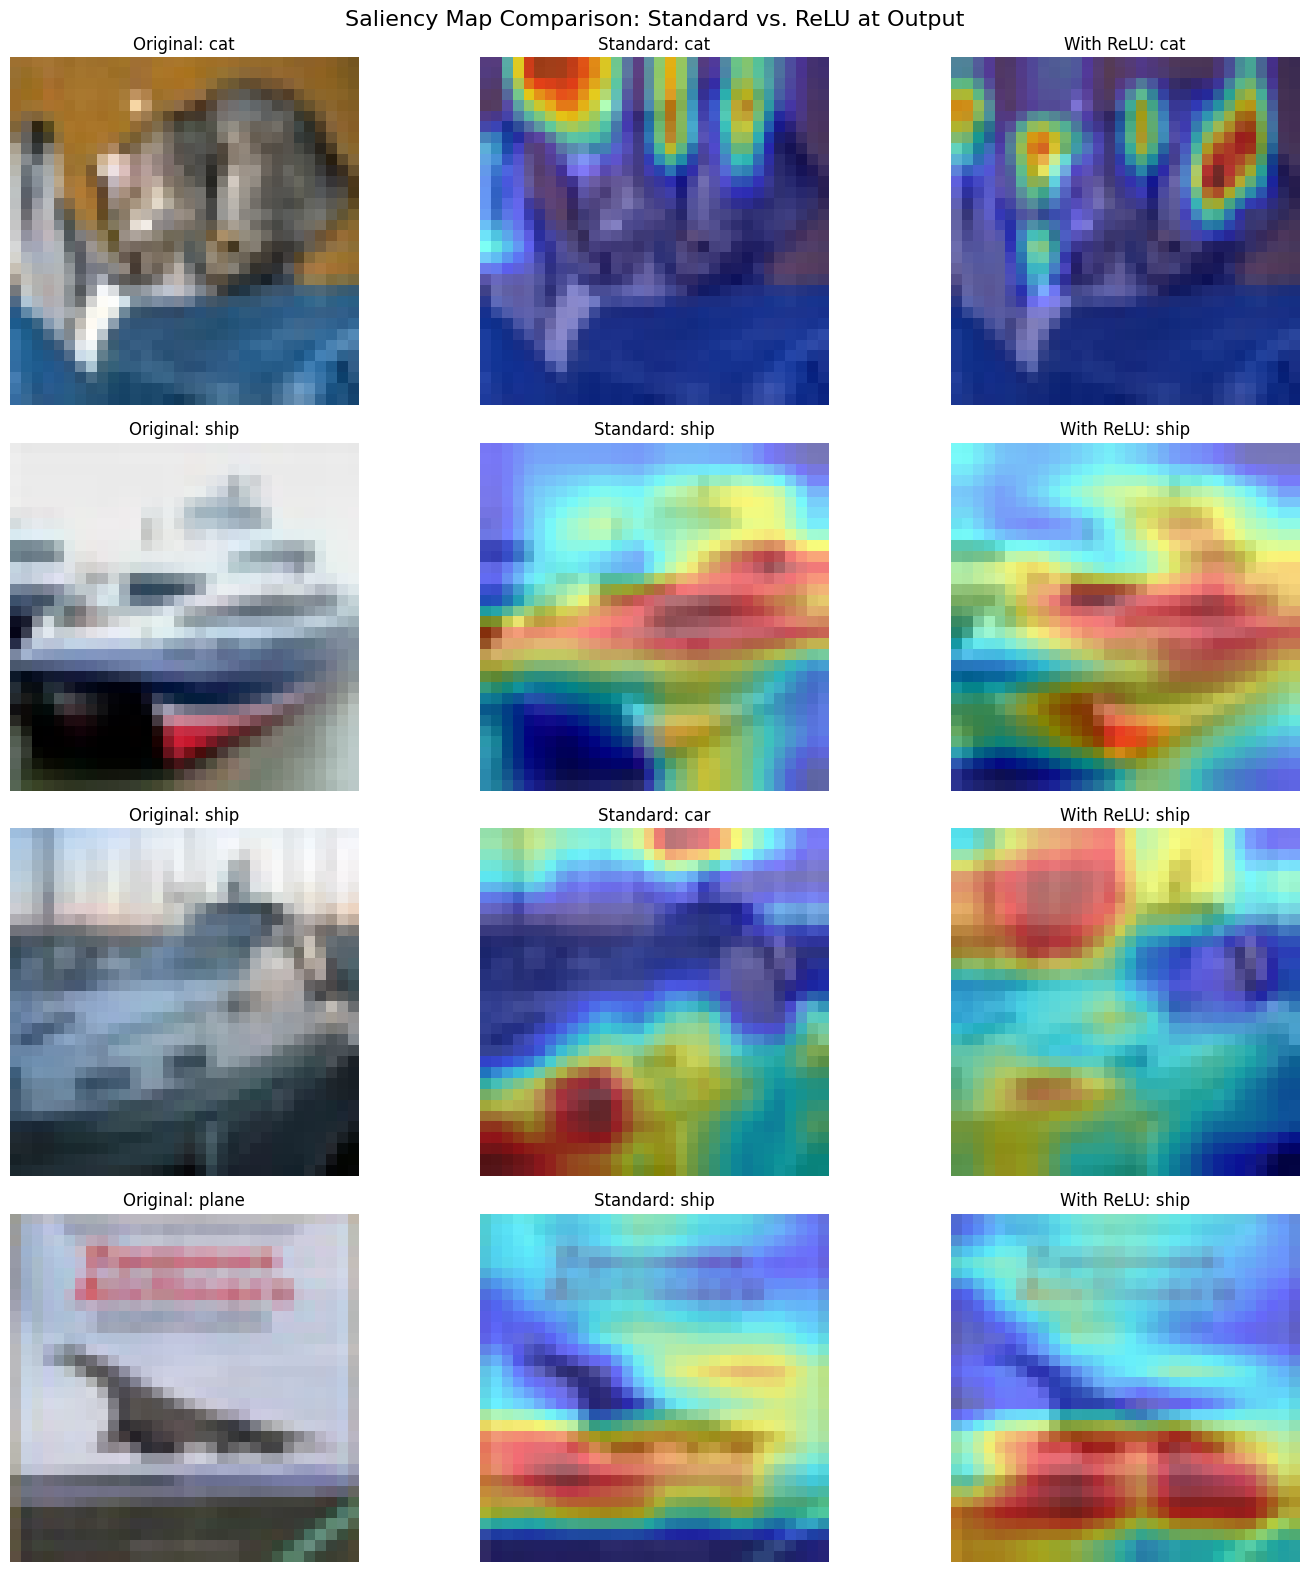

In [39]:
# Let's also create a direct comparison between the two models
def compare_saliency_maps():
    """
    Generate and compare saliency maps between the two models
    """
    # Get a batch of test images
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    # Create a figure for comparison
    fig, axes = plt.subplots(4, 3, figsize=(15, 16))
    fig.suptitle('Saliency Map Comparison: Standard vs. ReLU at Output', fontsize=16)

    # Target layer for visualization
    target_layer_std = [net_standard.conv2]
    target_layer_relu = [net_with_relu.conv2]

    # Initialize GradCAM for both models
    cam_std = GradCAM(model=net_standard, target_layers=target_layer_std)
    cam_relu = GradCAM(model=net_with_relu, target_layers=target_layer_relu)

    # Get predictions
    outputs_std = net_standard(images)
    outputs_relu = net_with_relu(images)
    _, predicted_std = torch.max(outputs_std, 1)
    _, predicted_relu = torch.max(outputs_relu, 1)

    for i in range(4):  # Process first 4 images
        # Original image
        img = images[i].cpu().numpy().transpose(1, 2, 0)
        img = img / 2 + 0.5  # unnormalize

        # Generate saliency maps for both models
        input_tensor = images[i].unsqueeze(0)

        # Standard model saliency
        grayscale_cam_std = cam_std(input_tensor=input_tensor, targets=None)
        grayscale_cam_std = grayscale_cam_std[0, :]
        vis_std = show_cam_on_image(img, grayscale_cam_std, use_rgb=True)

        # ReLU model saliency
        grayscale_cam_relu = cam_relu(input_tensor=input_tensor, targets=None)
        grayscale_cam_relu = grayscale_cam_relu[0, :]
        vis_relu = show_cam_on_image(img, grayscale_cam_relu, use_rgb=True)

        # Display original image
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Original: {classes[labels[i]]}')
        axes[i, 0].axis('off')

        # Display standard model saliency
        axes[i, 1].imshow(vis_std)
        axes[i, 1].set_title(f'Standard: {classes[predicted_std[i]]}')
        axes[i, 1].axis('off')

        # Display ReLU model saliency
        axes[i, 2].imshow(vis_relu)
        axes[i, 2].set_title(f'With ReLU: {classes[predicted_relu[i]]}')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Generate side-by-side comparison
print("\nGenerating side-by-side comparison of saliency maps...")
compare_saliency_maps()

In [40]:
del dataiter